# **Convolutions**

<a href="https://colab.research.google.com/github/stared/thinking-in-tensors-writing-in-pytorch/blob/master/convnets/Convolutions.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true)

Convolution (properly cross-correlation) is an operation on kernel and input data. It consists of following steps:
* Place the kernel above the input data
* Perform an elementwise multiplication between kernel elements and overlaping input elements and sum the products
* Repeat for all pixels of the input data

Each convolution layer produces new channels based on those which preceded it. First, we start with 3 channels for red, green and blue (RGB) components. Next, channels get more and more abstract.

While producing new channels with representations of various properties of the image, we also reduce the resolution, usually using pooling layers.

Source of the gif: [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)

In [1]:
!pip install matplotlib==3.1.0
import torch
from torch import utils
from torchvision import transforms
import torchvision
from PIL import Image
import requests
from io import BytesIO
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## Tic-tac-toe

Firstly, we will play with an one-channel tic-tac-toe board. Let's look at 6 kernels which will try to detect 6 particular patterns at the tic-tac-toe bord. 

In [0]:
class Tic_tac_toe():

  def __init__(self, width, height):
    self.width = width
    self.height = height
    self.board = torch.zeros(4*width+3, 4*height+3)

  def place_X(self, x, y):
    x_pos = 4*x + 3
    y_pos = 4*y + 3
    dx = [-1, 1, 1, -1]
    dy = [-1, 1, -1, 1]
    for i, j in zip(dx, dy):
      self.board[y_pos+i][x_pos+j] = 1.0
    self.board[y_pos][x_pos] = 1.0

  def place_O(self, x, y):
    x_pos = 4*x + 3
    y_pos = 4*y + 3
    dx = [-1, 1, 0, 0]
    dy = [0, 0, -1, 1]
    for i, j in zip(dx, dy):
      self.board[y_pos+i][x_pos+j] = 1.0

  def fill_up(self, X, O):
    for (x, y) in X:
      self.place_X(x, y)

    for (x, y) in O:
      self.place_O(x, y)

  def __str__(self):
    return str(self.board)

  def draw(self):
    plt.imshow(self.board, cmap="gray")
    plt.show()



Create a tic-tac-toe board of preferred size and place marks on it.

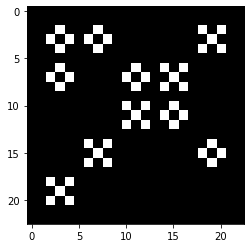

In [60]:
#@title Create a tic-tac-toe board
width = 5 #@param {type:"integer"}
height = 5 #@param {type:"integer"}
place_X = [(4, 0), (3, 1), (2, 2), (1, 3), (0, 4)] #@param {}
place_O = [(0, 0), (0, 1), (1, 0), (2, 1), (3, 2), (4, 3)] #@param {}

tic_tac_toe = Tic_tac_toe(5, 5)
tic_tac_toe.fill_up(X=place_X, O=place_O)
board = tic_tac_toe.board
tic_tac_toe.draw()

In [0]:
def visualize_kernels(kernels, s=3, annot=True, l=0):
    columns = len(kernels)
    fig, axs = plt.subplots(1, columns, figsize=(s*columns, s))
    j = 0
    #axs = axs.reshape(1, columns)
    for k in kernels.keys():
        ax = axs[j]
        ax.set_title(k)
        #ax.imshow(kernels[j].squeeze(dim=0).squeeze(dim=0), cmap="gray")
        #print(k)
        sns.heatmap(kernels[k].squeeze(dim=0).squeeze(dim=0), ax=ax, annot=annot, cbar=False, linewidths=l, cmap="YlGnBu", fmt=".1f")
        ax.axis('off')
        j = j+1

Now, let's look at 2 kernels, which will help us with the analisis of the board.

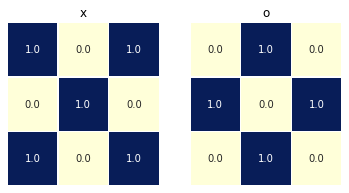

In [62]:
x_o_kernels = {
    'x': torch.tensor([[[[1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0]]]]),
    'o': torch.tensor([[[[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]]]])
}
visualize_kernels(x_o_kernels, l=.5)

Firstly, we apply the **x** kernel and **o** kernel to the input image respectively. As you can see, places where crosses and circles were located have now the biggest values.

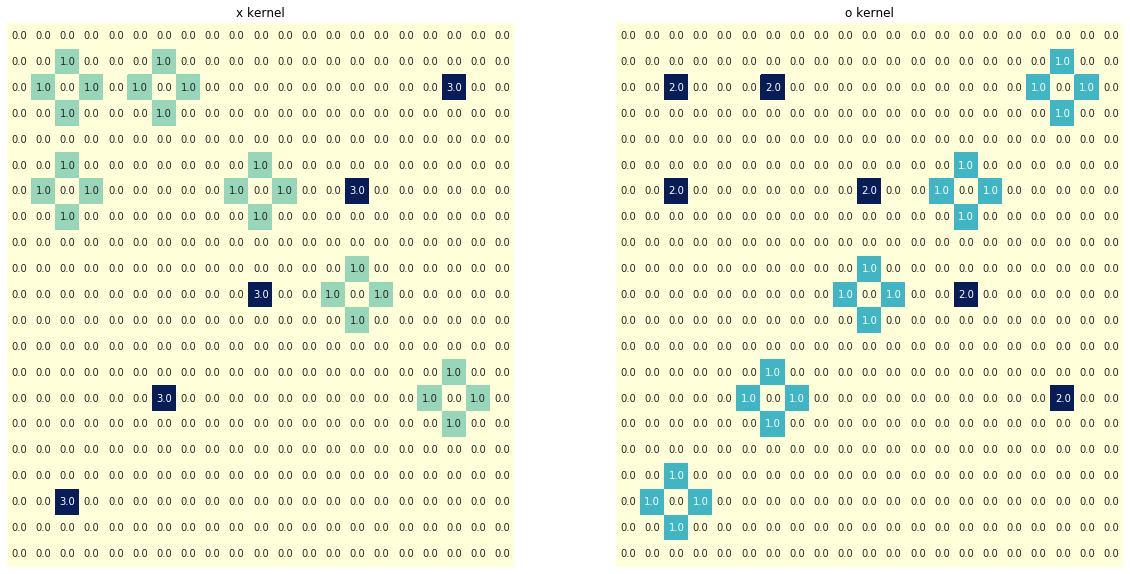

In [67]:
#@title Specify bias and activation function:
bias = 0 #@param {type:"slider", min:-5, max:5, step:0.5}
activation_function = "Identity" #@param ["Identity", "ReLU", "Sigmoid"]
id = lambda x: x
functions = {'Identity': id, 'ReLU':torch.relu, 'Sigmoid':torch.sigmoid}
activation = functions[activation_function]

layer1 = {k+' kernel': activation(torch.conv2d(board.unsqueeze(dim=0).unsqueeze(dim=0), v)+bias) 
                                                              for (k, v) in x_o_kernels.items()}
visualize_kernels(layer1, s=10)

Try changing the bias value, so places where crosses and circles were located are more visible. You can also add the activation function.

To make it even more clear, let's apply max pooling operation. Out of every four pixels we will choose one with the greatest value.



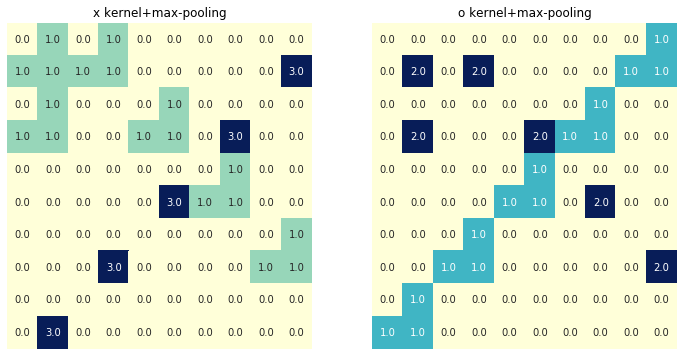

In [68]:
#@title Specify pooling:
pooling_kernel_size = 2 #@param {type:"number"}
pooling_type = "max-pooling" #@param ["max-pooling", "avg-pooling"]
types = {'avg-pooling':F.avg_pool2d, 'max-pooling':F.max_pool2d}
pooling = types[pooling_type]
layer1_pooling = {k+'+'+pooling_type: pooling(v, pooling_kernel_size) 
                                          for (k, v) in layer1.items()}
visualize_kernels(layer1_pooling, s=6)

Sometimes, we don't have to use max pooling of size 2 here. You can try to use average pooling here  or choose a different size of the kernel.

Finally, we can use 4 more kernels to find lines of croses and circles.

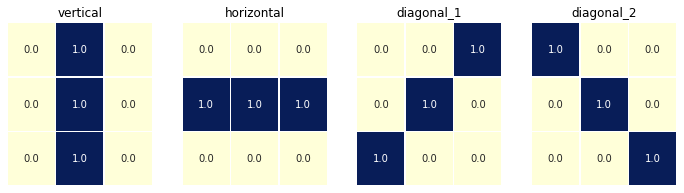

In [54]:
line_kernels = {
    'vertical': torch.tensor([[[[0.0, 1.0, 0.0],
                                  [0.0 ,1.0, 0.0], 
                                  [0.0, 1.0, 0.0]]]]),
    'horizontal': torch.tensor([[[[0.0, 0.0, 0.0],
                                    [1.0, 1.0, 1.0], 
                                    [0.0, 0.0, 0.0]]]]),
    'diagonal_1': torch.tensor([[[[0.0, 0.0, 1.0],
                                  [0.0, 1.0, 0.0],
                                  [1.0, 0.0, 0.0]]]]),
    'diagonal_2': torch.tensor([[[[1.0, 0.0, 0.0],
                                   [0.0, 1.0, 0.0],
                                   [0.0, 0.0, 1.0]]]])

}
visualize_kernels(line_kernels, l=.5)

Let's use remaining kernels combined with max pooling and ReLU to see, where whole lines of crosses and circles where located.

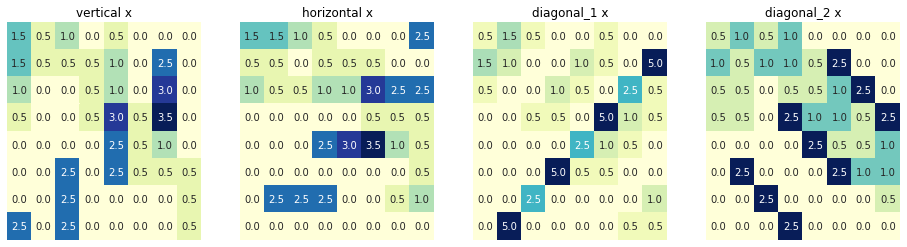

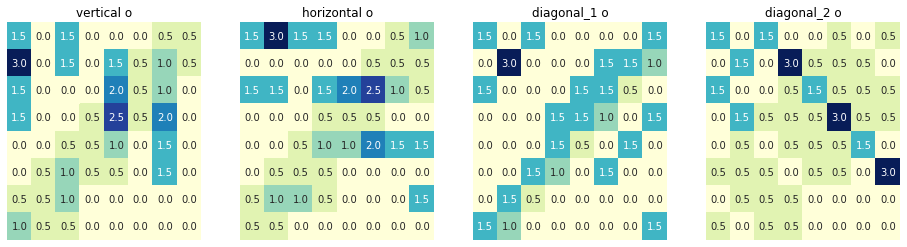

In [55]:
layer1_ = list(layer1_pooling_activation.values())
layer2_x = {k+' x':torch.conv2d(layer1_[0], v) for (k, v) in line_kernels.items()}
layer2_o = {k+' o':torch.conv2d(layer1_[1], v) for (k, v) in line_kernels.items()}
visualize_kernels(layer2_x, s=4)
visualize_kernels(layer2_o, s=4)

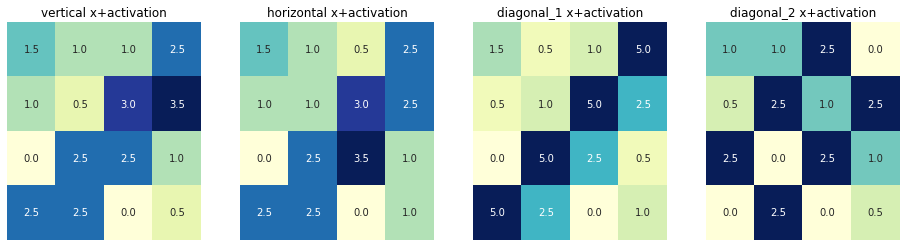

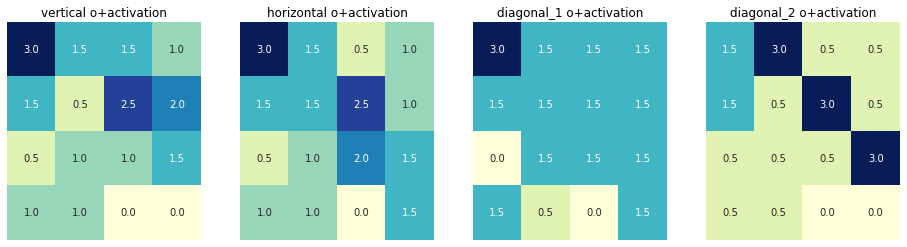

In [66]:
#@title Specify second layer parameters:
pooling_kernel_size = 2 #@param {type:"number"}
pooling_type = "max-pooling" #@param ["max-pooling", "avg-pooling"]
types = {'avg-pooling':F.avg_pool2d, 'max-pooling':F.max_pool2d}
pooling = types[pooling_type]
bias = 0 #@param {type:"slider", min:-5, max:5, step:0.5}
id = lambda x: x
activation_function = "Identity" #@param ["Identity", "ReLU", "Sigmoid"]
functions = {'Identity': id, 'ReLU':torch.relu, 'Sigmoid':torch.sigmoid}
activation = functions[activation_function]

layer2_x_activation = {k+'+activation':pooling(activation(v+bias), pooling_kernel_size) for (k, v) in layer2_x.items()}
layer2_o_activation = {k+'+activation':pooling(activation(v+bias), pooling_kernel_size) for (k, v) in layer2_o.items()}
visualize_kernels(layer2_x_activation, s=4)
visualize_kernels(layer2_o_activation, s=4)

## Bigger picture

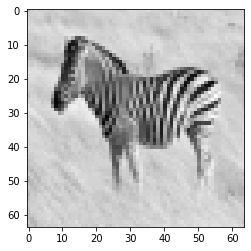

In [80]:
#@markdown ### Enter a path with the photo:
#"https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png"
#"https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Common_zebra_1.jpg/250px-Common_zebra_1.jpg"

file_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Common_zebra_1.jpg/250px-Common_zebra_1.jpg" #@param {type:"string"}

if ":" in file_path:
    response = requests.get(file_path)
    img = Image.open(BytesIO(response.content))
else:
    img = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((64, 64)),                              
    transforms.Grayscale(),
    transforms.ToTensor()])

img_tensor = transform(img)
plt.imshow(img_tensor.squeeze(dim=0), cmap="gray")
#img = transforms.ToPILImage()(img_tensor)
#img_tensor = img_tensor.unsqueeze(dim=0)

#img.resize((200, 200))

In [0]:
sobel_vertical_kernel = torch.tensor([[[[-1.0, 0.0, 1.0],
                              [-2.0 ,0.0, 2.0], 
                              [-1.0, 0.0, 1.0]]]])

sobel_horizontal_kernel = torch.tensor([[[[-1.0, -2.0, -1.0],
                              [0.0 ,0.0, 0.0], 
                              [1.0, 2.0, 1.0]]]])


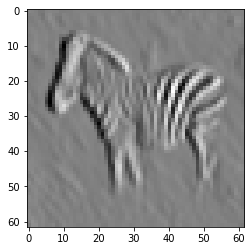

In [82]:
zebra_with_sobel_vertical = torch.conv2d(img_tensor.unsqueeze(dim=0), sobel_vertical_kernel)
plt.imshow(zebra_with_sobel_vertical.squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()

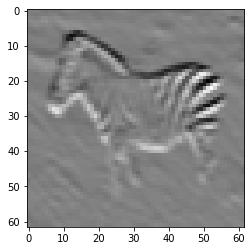

In [83]:
zebra_with_sobel_horizontal = torch.conv2d(img_tensor.unsqueeze(dim=0), sobel_horizontal_kernel)
plt.imshow(zebra_with_sobel_horizontal.squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()

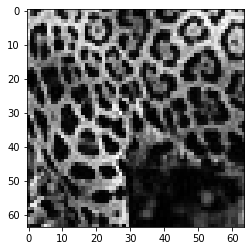

In [88]:

#@markdown ### Enter a path with the photo:
#"https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png"
#"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Standing_jaguar.jpg/220px-Standing_jaguar.jpg"

file_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Standing_jaguar.jpg/220px-Standing_jaguar.jpg" #@param {type:"string"}
#@markdown ---
if ":" in file_path:
    response = requests.get(file_path)
    img = Image.open(BytesIO(response.content))
else:
    img = Image.open(file_path)

transform = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor()])

img_tensor2 = transform(img)
plt.imshow(img_tensor2.squeeze(dim=0), cmap="gray")

In [0]:
circle_kernel = torch.tensor([[[[-2.0, -1.0, 0.0, -1.0, -2.0],
                                [-2.0, 0.0, 1.0, 0.0, -2.0],
                                [0.0, 1.0, 2.0, 1.0, 0.0],
                                [-2.0, 0.0, 1.0, 0.0, -2.0],
                                [-2.0, -1.0, 0.0, -1.0, -2.0]
                              ]]])

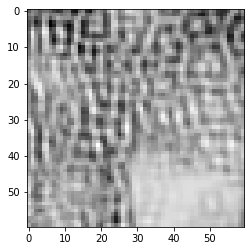

In [90]:
jaguar_with_circle = torch.conv2d(img_tensor2.unsqueeze(dim=0), circle_kernel)
plt.imshow(jaguar_with_circle.squeeze(dim=0).squeeze(dim=0), cmap="gray")
plt.show()